In [ ]:
import pandas as pd

df = pd.read_csv("/content/df_final_selected_features.csv")

### **PERFIL DEMOGRÁFICO**

No perfil demográfico estamos tentando responder perguntas como:

Quais características demográficas estão associadas a maior risco de inadimplência?

In [ ]:
# No Home Credit, DAYS_BIRTH é negativo. Precisamos converter para idade em anos, que é mais interpretável para negócio
df["AGE_YEARS"] = (-df["DAYS_BIRTH"] / 365).round(1)

**- Distribuição de Idade**

In [ ]:
# Análise Descritiva
df["AGE_YEARS"].describe().round(2)

,AGE_YEARS
count,307511.00
mean,43.94
std,11.96
min,20.50
25%,34.00
50%,43.20
75%,53.90
max,69.10


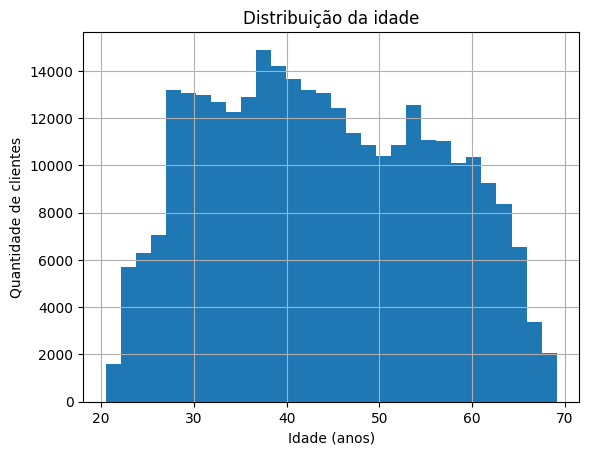

In [ ]:
import matplotlib.pyplot as plt

# Histograma distribuição geral da idade
df["AGE_YEARS"].hist(bins=30)

plt.xlabel("Idade (anos)")
plt.ylabel("Quantidade de clientes")
plt.title("Distribuição da idade")

plt.show()


Com a análise descritiva e observando o histograma podemos observar que a distribuição de idade é equilibrada, com média próxima à mediana, indicando ausência de viés etário na base.
A maior concentração de clientes está entre 34 e 54 anos, uma faixa economicamente ativa.
A variável é consistente e adequada para segmentação em faixas etárias visando capturar padrões não lineares de risco de crédito.

**- Idade vs Inadimplência**

In [ ]:
# Taxa média de inadimplência por faixa etária
age_default_rate = (
    df.groupby(pd.cut(df["AGE_YEARS"], bins=[18, 25, 35, 45, 55, 65, 75]))
      ["TARGET"]
      .mean().round(2)
)

age_default_rate

/tmp/ipython-input-203108233.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["AGE_YEARS"], bins=[18, 25, 35, 45, 55, 65, 75]))


,TARGET
AGE_YEARS,
"(18, 25]",0.12
"(25, 35]",0.11
"(35, 45]",0.08
"(45, 55]",0.07
"(55, 65]",0.05
"(65, 75]",0.04


Na tabela acima observa-se uma relação inversa entre idade e inadimplência: clientes mais jovens apresentam maior taxa de inadimplência.
A taxa cai progressivamente a partir dos 35 anos, indicando maior estabilidade financeira com o avanço da idade.
Esse padrão pode justificar uma criação de bins etários como feature, capturando o efeito não linear da idade no risco de crédito.

**- Tempo de emprego**

In [ ]:
'''Esse código transforma a variável DAYS_EMPLOYED em anos de vínculo empregatício, corrigindo a codificação negativa do dataset Home Credit.
Valores positivos, que indicam clientes desempregados, são tratados como NaN para evitar distorções '''

df["EMPLOYED_YEARS"] = df["DAYS_EMPLOYED"].apply(
    lambda x: -x / 365 if x < 0 else None
)

In [ ]:
# Análise descritiva
df["EMPLOYED_YEARS"].describe().round(2)

,EMPLOYED_YEARS
count,252135.00
mean,6.53
std,6.41
min,0.00
25%,2.10
50%,4.52
75%,8.70
max,49.07


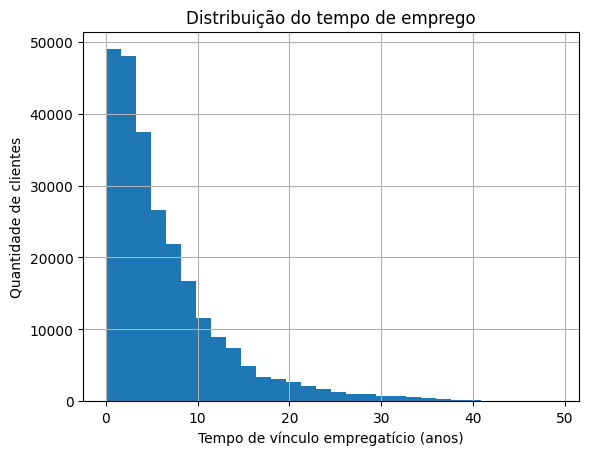

In [ ]:
# Histograma para visualizar a distribuição do tempo de emprego
df["EMPLOYED_YEARS"].hist(bins=30)

plt.xlabel("Tempo de vínculo empregatício (anos)")
plt.ylabel("Quantidade de clientes")
plt.title("Distribuição do tempo de emprego")

plt.show()


O tempo médio de emprego é de aproximadamente 6,5 anos, com alta dispersão, indicando perfis variados de estabilidade profissional.
Metade dos clientes possui até 4,5 anos de vínculo, enquanto o quartil superior ultrapassa 8,7 anos, sugerindo uma maior maturidade financeira.
Essa variável é pode ser uma forte candidata para feature engineering via faixas de estabilidade (baixo, médio ou alto vínculo)

**- Tempo de emprego vs Inadimplência**

In [ ]:
# Taxa média de inadimplência por tempo de emprego
emp_default_rate = (
    df.groupby(pd.cut(df["EMPLOYED_YEARS"], bins=[0, 1, 3, 5, 10, 20, 40]))
      ["TARGET"]
      .mean().round(2)
)

emp_default_rate

/tmp/ipython-input-3676638311.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["EMPLOYED_YEARS"], bins=[0, 1, 3, 5, 10, 20, 40]))


,TARGET
EMPLOYED_YEARS,
"(0, 1]",0.11
"(1, 3]",0.11
"(3, 5]",0.10
"(5, 10]",0.07
"(10, 20]",0.06
"(20, 40]",0.04


Observa-se uma relação inversa clara entre tempo de emprego e inadimplência: quanto maior a estabilidade profissional, menor o risco de inadimplência.
Clientes com até 3 anos de vínculo apresentam taxas próximas de 11%, enquanto acima de 20 anos o risco cai para cerca de 4% validando que clientes mais velhos tem mais estabilidade financeira, por isso, menos chance de inadimplência.
Esse comportamento valida a criação de features categóricas fortes de estabilidade, potencialmente mais informativas que o valor contínuo.

## **Análise por Gênero**

In [ ]:
import plotly.express as px

# Distribuição de clientes por gênero (exclui XNA)
gender_dist = (
    df[df["CODE_GENDER"] != "XNA"]   # remove XNA
    .groupby("CODE_GENDER")
    .size()
    .reset_index(name="count")
)

# Gráfico de barras da distribuição por gênero
fig = px.bar(
    gender_dist,
    x="CODE_GENDER",
    y="count",
    color="CODE_GENDER",
    title="Distribuição de Clientes por Gênero",
    labels={
        "CODE_GENDER": "Gênero",
        "count": "Número de Clientes"
    }
)

# Ajustes visuais do gráfico
fig.update_layout(
    width=800,   # largura
    height=500,   # altura
    title_x=0.5  # centraliza o título
)


fig.show()


A carteira de crédito é majoritariamente composta por mulheres, que representam cerca de dois terços dos clientes.
Esse desbalanceamento indica que métricas globais de risco são mais influenciadas pelo perfil feminino.
Portanto, análises de inadimplência devem ser normalizadas por gênero para evitar interpretações enviesadas.

**- Gênero × Tempo de Emprego × Inadimplência**

In [ ]:
# Filtra clientes com gênero válido e tempo de emprego conhecido
df_gender = df[
    (df["CODE_GENDER"].isin(["M", "F"])) &
    (df["EMPLOYED_YEARS"].notna())
]

# Cria faixas de tempo de emprego
df_gender["EMPLOYED_BIN"] = pd.cut(
    df_gender["EMPLOYED_YEARS"],
    bins=[0, 1, 3, 5, 10, 20, 50]
).astype(str)

# Taxa média de inadimplência por gênero e faixa de emprego
gender_emp_default = (
    df_gender.groupby(
        ["CODE_GENDER", "EMPLOYED_BIN"],
        observed=True
    )["TARGET"]
    .mean()
    .reset_index()
)

# Ordem correta dos bins
bin_order = [
    "(0, 1]",
    "(1, 3]",
    "(3, 5]",
    "(5, 10]",
    "(10, 20]",
    "(20, 50]"
]

# Gráfico de inadimplência por gênero e tempo de emprego
fig = px.bar(
    gender_emp_default,
    x="EMPLOYED_BIN",
    y="TARGET",
    color="CODE_GENDER",
    barmode="group",
    title="Inadimplência por Gênero e Tempo de Emprego",
    labels={
        "EMPLOYED_BIN": "Tempo de Emprego (anos)",
        "TARGET": "Taxa de Inadimplência",
        "CODE_GENDER": "Gênero"
    },
    category_orders={
        "EMPLOYED_BIN": bin_order
    }
)

# Ajustes visuais do gráfico
fig.update_layout(
    width=800,
    height=500,
    title_x=0.5
)

fig.show()


/tmp/ipython-input-3813358346.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A taxa de inadimplência diminui conforme aumenta o tempo de emprego para ambos os gêneros, indicando estabilidade profissional como fator protetivo. Em todos os intervalos, homens apresentam inadimplência consistentemente maior que mulheres. A diferença é mais acentuada nos primeiros anos de emprego.

In [ ]:
# Filtra clientes com gênero válido e idade conhecida
df_gender = df[
    (df["CODE_GENDER"].isin(["M", "F"])) &
    (df["AGE_YEARS"].notna())
]

# Criando bins de idade e convertendo para string (necessário para o Plotly)
df_gender["AGE_BIN"] = pd.cut(
    df["AGE_YEARS"],
    bins=[18, 25, 35, 45, 55, 65, 75]
).astype(str)


# Calcula inadimplência média por gênero e faixa etária
gender_age_default = (
    df_gender.groupby(
        ["CODE_GENDER", "AGE_BIN"],
        observed=True
    )["TARGET"]
    .mean()
    .reset_index()
)

# Ordem correta das faixas etárias
age_order = [
    "(18, 25]",
    "(25, 35]",
    "(35, 45]",
    "(45, 55]",
    "(55, 65]",
    "(65, 75]"
]

# Gráfico de inadimplência por gênero e faixa etária
fig = px.bar(
    gender_age_default,
    x="AGE_BIN",
    y="TARGET",
    color="CODE_GENDER",
    barmode="group",
    title="Inadimplência por Gênero e Faixa Etária",
    labels={
        "AGE_BIN": "Faixa Etária",
        "TARGET": "Taxa de Inadimplência",
        "CODE_GENDER": "Gênero"
    },
    category_orders={
        "AGE_BIN": age_order # Ordem correta dos bins
    }
)

# Ajustes visuais do gráfico
fig.update_layout(
    width=800,
    height=500,
    title_x=0.5
)

fig.show()


/tmp/ipython-input-4033361051.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A taxa de inadimplência diminui consistentemente com o aumento da idade para ambos os gêneros. Em todas as faixas etárias, homens apresentam maior inadimplência do que mulheres, especialmente nas faixas mais jovens. Homens, especialmente mais jovens, costumam assumir mais risco financeiro (crédito maior, menor reserva, maior alavancagem), o que se reflete em taxas mais altas de inadimplência. Mulheres tendem a apresentar comportamento financeiro mais cauteloso e previsível. A diferença entre os gêneros tende a reduzir conforme a idade avança.

Esse comportamento sugere que idade interage fortemente com gênero no risco de crédito, justificando a criação de features como faixa etária ponderada por gênero ou interações que podem capturar melhor padrões não lineares no modelo.